# Understanding Deepfakes with Keras

![DCGAN](DCGAN.png)

# Task 1: Importing Libraries and Helper Functions

Please note: If you haven't already, please install the required packages by executing the code cell below.

In [1]:
%matplotlib notebook

import tensorflow as tf
import numpy as np
import os
import tfutils

from matplotlib import pyplot as plt
from tensorflow.keras.layers import Dense, Flatten, Conv2D, BatchNormalization
from tensorflow.keras.layers import Conv2DTranspose, Reshape, LeakyReLU
from tensorflow.keras.models import Model, Sequential
from PIL import Image

print('TensorFlow version:', tf.__version__)

TensorFlow version: 2.1.0


# Task 2: Importing and Plotting the Data

In [3]:
(x_train, y_train), (x_test, y_test) = tfutils.datasets.mnist.load_data(one_hot=False)

#loading subsets of class 0
x_train = tfutils.datasets.mnist.load_subset([0], x_train, y_train )

x_test = tfutils.datasets.mnist.load_subset([0], x_test, y_test )

#concatenating around rows
x= np.concatenate([x_train, x_test], axis=0)

<IPython.core.display.Javascript object>


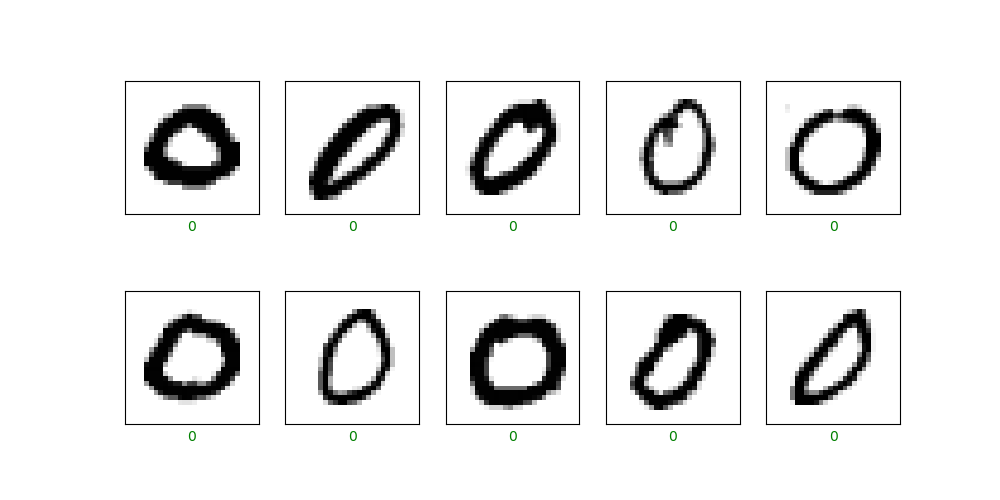

In [6]:
#plot some random samples of class 0s
tfutils.datasets.mnist.plot_ten_random_examples(plt, x, np.zeros((x.shape[0], 1))).show()

# Task 3: Discriminator

![Artist and Critic](artist_critic.png)

In [11]:
#implementation of the discriminator from paper 2015 DCGANS

discriminator = Sequential([
    
    Conv2D(64, 3, strides=2, input_shape=(28,28,1)),   #input shape is grayscale hence (28,28,1)
    LeakyReLU(),
    BatchNormalization(),
    
    Conv2D(128, 5, strides=2),
    LeakyReLU(),
    BatchNormalization(),
    
    Conv2D(256, 5, strides=2),
    LeakyReLU(),
    BatchNormalization(),
    
  
    Flatten(),
    Dense(1, activation='sigmoid')
    
])

#create a optimizer
opt = tf.keras.optimizers.Adam(lr=2e-4, beta_1=0.5)

#compile
discriminator.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])

#have a look at summary
discriminator.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_7 (Conv2D)            (None, 13, 13, 64)        640       
_________________________________________________________________
leaky_re_lu_6 (LeakyReLU)    (None, 13, 13, 64)        0         
_________________________________________________________________
batch_normalization_6 (Batch (None, 13, 13, 64)        256       
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 5, 5, 128)         204928    
_________________________________________________________________
leaky_re_lu_7 (LeakyReLU)    (None, 5, 5, 128)         0         
_________________________________________________________________
batch_normalization_7 (Batch (None, 5, 5, 128)         512       
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 1, 1, 256)        

# Task 4: Generator

In [14]:
#Generator
generator = Sequential([
    Dense(256, activation='relu', input_shape=(1,)),
    Reshape((1, 1, 256)),
    
    Conv2DTranspose(256, 5, activation='relu'),
    BatchNormalization(),
    
    Conv2DTranspose(128, 5, activation='relu'),
    BatchNormalization(),
    
    Conv2DTranspose(64, 5, strides=2, activation='relu'),
    BatchNormalization(),
    
    Conv2DTranspose(32, 5, activation='relu'),
    BatchNormalization(),
        
    Conv2DTranspose(1,4, activation='sigmoid')

])



#summary of generator
generator.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_5 (Dense)              (None, 256)               512       
_________________________________________________________________
reshape_2 (Reshape)          (None, 1, 1, 256)         0         
_________________________________________________________________
conv2d_transpose_8 (Conv2DTr (None, 5, 5, 256)         1638656   
_________________________________________________________________
batch_normalization_17 (Batc (None, 5, 5, 256)         1024      
_________________________________________________________________
conv2d_transpose_9 (Conv2DTr (None, 9, 9, 128)         819328    
_________________________________________________________________
batch_normalization_18 (Batc (None, 9, 9, 128)         512       
_________________________________________________________________
conv2d_transpose_10 (Conv2DT (None, 21, 21, 64)       

<IPython.core.display.Javascript object>


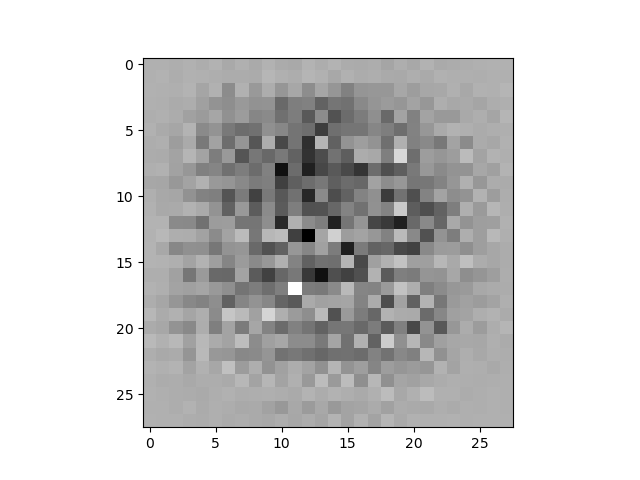

In [15]:
#create noise to test
noise = np.random.randn(1,1)

gen_image= generator. predict(noise)[0]

plt.figure()
plt.imshow(np.reshape(gen_image, (28,28)), cmap='binary')
plt.show()

# Task 5: Generative Adversarial Network (GAN)

In [17]:
#compiling my gan
input_layer= tf.keras.layers.Input(shape=(1,))

gen_out= generator(input_layer)

disc_out= discriminator(gen_out)

gan= Model (
    
    input_layer, 
    disc_out
    
)

discriminator.trainable= False
gan.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])
gan.summary()



Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 1)]               0         
_________________________________________________________________
sequential_5 (Sequential)    (None, 28, 28, 1)         2717025   
_________________________________________________________________
sequential_2 (Sequential)    (None, 1)                 1027073   
Total params: 3,744,098
Trainable params: 2,716,065
Non-trainable params: 1,028,033
_________________________________________________________________


# Tasks 6 and 7: Training the GAN

In [18]:
#training a GAN

epochs= 25
batch_size = 128
steps_per_epoch = int(2 *x.shape[0]/batch_size)

print('Steps for epoch=', steps_per_epoch)


Steps for epoch= 107


<IPython.core.display.Javascript object>


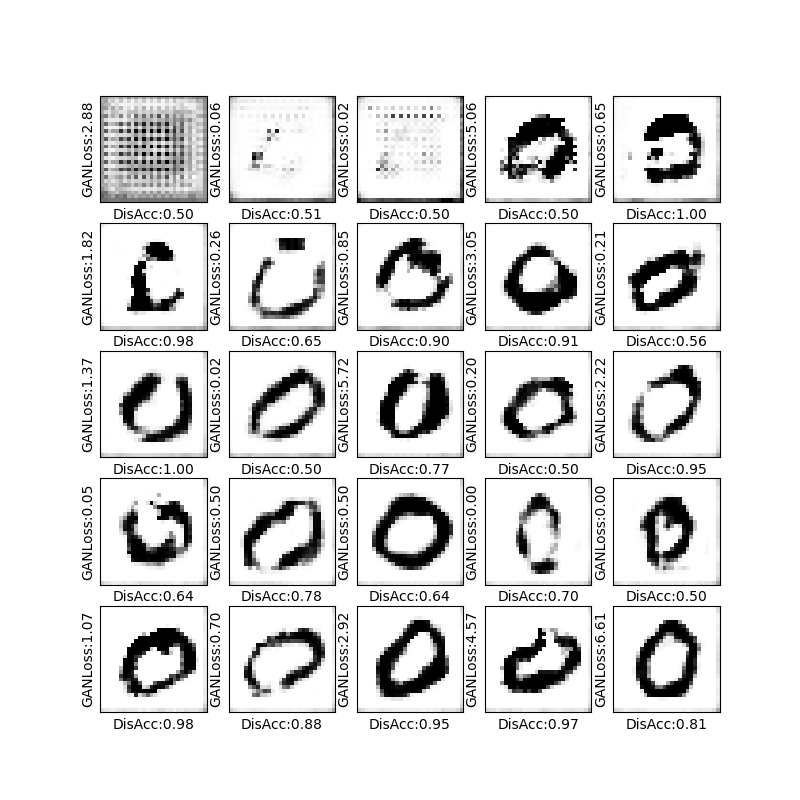

In [23]:
dp = tfutils.plotting.DynamicPlot(plt, 5,5, (8,8))

for e in range(0, epochs):
    dp.start_of_epoch(e)
    
    for step in range(0, steps_per_epoch):
        true_examples = x[int(batch_size/2)*step:int(batch_size/2)*(step+1)]
        true_examples = np.reshape(true_examples, (true_examples.shape[0], 28, 28, 1))
        
        noise = np.random.randn(int(batch_size/2), 1)
        gen_examples = generator.predict(noise)
        
        x_batch = np.concatenate([gen_examples, true_examples], axis=0)
        y_batch = np.array([0]*int(batch_size/2) + [1]*int(batch_size/2))
        
        indices = np. random.choice(range(batch_size), batch_size, replace= False)
        
        x_batch= x_batch[indices]
        y_batch= y_batch[indices]
        
        #train discriminator
        discriminator.trainable- True
        discriminator.train_on_batch(x_batch, y_batch)
        discriminator.trainable = False
        
        #train generator
        loss, _= gan.train_on_batch(noise, np.ones((int(batch_size/2), 1)))
        _, acc = discriminator.evaluate(x_batch, y_batch, verbose=False)
        
    noise= np.random.randn(1,1)
    gen_image = generator.predict(noise)[0]
    gen_image = np.reshape(gen_image, (28,28))
    dp.end_of_epoch(gen_image, 'binary', 'DisAcc:{:.2f}'.format(acc), 'GANLoss:{:.2f}'.format(loss))
        